In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import torch
from torch import nn

# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

#### Test Environment

In order to test this algorithm, we've created a very simple environment that should be easy for a working agent to solve. This isn't necessary for the PPO implementation, and is only used for testing.

In [3]:
class Environment:
    """ This is a very simple custom environment used for debugging and testing.
    The observation at timestep t is sin(2*t*pi/20)
    The agent starts at position 0
    The action space is one of 3 discrete moves:
        0: add 0.25 to the agent's position
        1: subtract 0.25 from the agent's position
        2: don't do anything
    
    The agent is rewarded +1 if, after moving, it's position at timestep t is within
    a distance of 0.25 from the observation.
    The agent is punished with -1 if, after moving, it's position is outside
    a distance of 0.5 from the observation.
    Otherwise, a reward of 0 is given.
    
    The environment terminates when the step hits max_steps (default 20)
    """
    def __init__(self):
        self.n_actions = 3
        self.n_obs = 2
        self.max_steps = 20
        self.space = np.sin(np.linspace(0,2*np.pi,self.max_steps))
        
    def reset(self):
        self.x = 0
        self.target = self.space[self.x]
        self.agent = self.space[self.x]
        self.state = [self.target, self.agent]
        
        self.x_data = []
        self.target_data = []
        self.agent_data = []
        return np.array(self.state)
    
    def step(self, action):
        self.x += 1
        self.target = self.space[self.x]
        if action == 0:
            pass
        if action == 1:
            self.agent += 0.25
        if action == 2:
            self.agent -= 0.25
            
        self.state = [self.target, self.agent]
        
        dist = abs(self.target - self.agent)
        reward = 0
        if dist < 0.25:
            reward = 1.
        if dist > 0.5:
            reward = -1.
            
        done = False
        if self.x >= self.max_steps - 1:
            done = True
            
        self.x_data.append(self.x)
        self.target_data.append(self.target)
        self.agent_data.append(self.agent)
            
        return np.array(self.state), reward, done, {}
    
    def get_render_data(self):
        return self.x_data, self.target_data, self.agent_data
    
    def render(self):
        plt.plot(self.x_data, self.target_data, '.')
        plt.plot(self.x_data, self.agent_data, '.')
        plt.show()

# Actor-Critic

In [62]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.Tanh(),
            nn.Linear(hidden_size//2, n_actions),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, X):
        return self.model(X)
    
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [5]:
env = gym.make("CartPole-v1")

In [8]:
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)

adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99

In [9]:
episode_rewards = []

for i in range(500):
    done = False
    total_reward = 0
    state = env.reset()


    while not done:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))
        
        total_reward += reward
        state = next_state

        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
            
    episode_rewards.append(total_reward)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


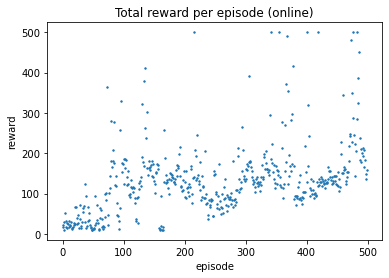

In [10]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (online)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

## PPO Agent

In [156]:
class Agent:
    def __init__(self, n_obs, n_actions,
                epsilon=0.2, gamma=0.99, entropy_loss=1e-3, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=128, debug=False):
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.debug = debug
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.gamma = gamma
        self.entropy_loss = entropy_loss
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = Actor(self.n_obs, self.n_actions, self.hidden_size)
        self.critic = Critic(self.n_obs, self.hidden_size)
        
        # Create Optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.critic_lr)
        
        # When we want predictions of actions, we need to pass in three things:
        # the observation, the old prob, and the advantage.
        # Here, we just created data to spoof the last two.
        self.DUMMY_ACTION, self.DUMMY_VALUE = np.zeros((1, self.n_actions)), np.zeros((1, 1))
    
    def ppo_loss(self, y_true, y_pred, advantage, old_pred, debug=False):
        # Defines the PPO loss to be used during actor optimization

        # advantage is a vector of size 1 passed in from the critic
        # This summing flattens it
        adv = torch.sum(advantage, dim=1).detach()
        if debug: print('advantage     :', adv)

        # y_true is one-hot vector denoting the action taken
        # y_pred is the output of the actor neural network
        # for the given observation
        # e.g., y_true = [0,1,0], y_pred = [0.2, 0.5, 0.3]
        # so prob = y_true * y_pred = [0, 0.5, 0]
        prob = t(y_true) * y_pred
        if debug: print('prob          :', prob)

        # old_pred is the actor's previous probabilty distribution
        # for the given observation
        # e.g., y_true = [0,1,0], old_pred = [0.2, 0.4, 0.4]
        # so prob = y_true * old_pred = [0, 0.4, 0]
        old_prob = t(y_true) * t(old_pred)
        if debug: print('old_prob      :', old_prob)

        # r is the ratio of the old probability to the new one
        # e.g., r = prob/old_prob = [0, 0.5/0.4, 0]
        r = torch.sum(prob/(old_prob + 1e-10), dim=1)
        if debug: print('r             :', r)

        # clipped is the value of r clipped between 1 +/- epsilon
        # e.g., r = 1.4, epsilon = 0.2 => clipped = 1.2
        clipped = torch.clamp(r, min=1-self.epsilon, max=1+self.epsilon)
        if debug: print('clipped       :', clipped)

        # minimum is the min of r * advantage and clipped * advantage
        minimum = torch.min(r * adv, clipped * adv)
        if debug: print('minimum       :', minimum)

        # entropy bonus (to encourage exploration)
        entropy_bonus = self.entropy_loss * (prob * torch.log(prob + 1e-10))
        entropy_bonus = torch.sum(entropy_bonus, dim=1)
        if debug: print('entropy_bonus :', entropy_bonus)

        # computes the mean over all dimensions (left with a scaler)
        result = -torch.mean(minimum + entropy_bonus)
        if debug: print('result        :', result)

        return result
    
    def get_action(self, observation):
        # Predict the probability destribution of the actions as a vactor
        obs = observation#.reshape(1, self.n_obs)
        # print('o', obs)
        # print('s', obs.shape)
            
        probs = self.actor(t(obs)).detach()
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample().detach().numpy()
        
        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.n_actions)
        action_vector[action] = 1
        
        return action, action_vector, probs.numpy()
    
    def train_batch(self, observations, actions, probabilities, rewards):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        acts = actions[:self.buffer_size]
        probs = probabilities[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        
        # our 'old probs' are really just the batches probs
        old_probs = probs
        
        # Calculate advantages
        values = self.critic(t(obs))
        advs = t(rews) - values
            
        # Train the actor and critic on the batch data
        for epoch in range(self.epochs):
            # TODO: batching
            actor_loss = self.ppo_loss(acts, self.actor(t(obs)), advs, old_probs)
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            y_pred_critic = self.critic(t(obs))
            critic_loss = torch.nn.MSELoss(reduction='sum')(
                y_pred_critic, t(rews)
            )
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
    
    def run(self, env, episodes, verbose=False):
        episode = 0
        reward_history = []

        # reset the environment
        observation = env.reset()

        # Collect a batch of samples
        while episode < episodes:
            # 'Master Batch' that we add mini batches to
            batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # Mini batch which contains a single episode's data
            tmp_batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }

            # While we don't hit the buffer size with our master batch...
            while len(batch['observation']) < self.buffer_size:
                # Get the action (scalar), action vector (one-hot vector), 
                # and probability distribution (vector) from the current observation
                action, action_vector, prob = self.get_action(observation)

                # Get the next observation, reward, done, and info for taking an action
                next_observation, reward, done, info = env.step(action)

                # Append the data to the mini batch
                tmp_batch['observation'].append(observation)
                tmp_batch['action_vector'].append(action_vector)
                tmp_batch['probability'].append(prob)
                tmp_batch['reward'].append(reward)

                # The current observation is now the 'next' observation
                observation = next_observation

                # if the episode is at a terminal state...
                if done:
                    # log some reward data (for plotting)
                    reward_data = np.sum(tmp_batch['reward'])
                    reward_history.append(reward_data)

                    # transform rewards based to discounted cumulative rewards
                    for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                        tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * self.gamma

                    # for each entry in the mini batch...
                    for i in range(len(tmp_batch['observation'])):
                        # we unpack the data
                        obs = tmp_batch['observation'][i]
                        act = tmp_batch['action_vector'][i]
                        prob = tmp_batch['probability'][i]
                        r = tmp_batch['reward'][i]

                        # and pack it into the master batch
                        batch['observation'].append(obs)
                        batch['action_vector'].append(act)
                        batch['probability'].append(prob)
                        batch['reward'].append(r)

                    # if we're using my custom environment,
                    # we record some more data for plotting
                    try:
                        x_data, target_data, agent_data = env.get_render_data()
                    except:
                        pass

                    # reset the environment
                    observation = env.reset()

                    # reset the mini batch
                    tmp_batch = {
                        'observation': [],
                        'action_vector': [],
                        'probability': [],
                        'reward': []
                    }

                    # increment the episode count
                    episode += 1

            # we've filled up our master batch, so we unpack it into numpy arrays
            observations = np.array(batch['observation'])
            actions = np.array(batch['action_vector'])
            probabilities = np.array(batch['probability'])
            rewards = np.array(batch['reward'])    
            rewards = np.reshape(rewards, (len(batch['reward']), 1))

            # train the agent on the batched data
            self.train_batch(observations, actions, probabilities, rewards)

            # every 10th episode, log some stuff
            if (episode % 10 == 0 or episode == episodes - 1) and verbose:
                print('Episode:', episode)
                print('Reward :', reward_data)
                print('Average:', np.mean(reward_history[-100:]))
                print('-'*10)
                print()
                
                try:
                    plt.plot(x_data, target_data, '.')
                    plt.plot(x_data, agent_data, '.')
                    plt.show()
                except:
                    pass
                    
        self.reward_history = reward_history
        return self.reward_history

<AxesSubplot:>

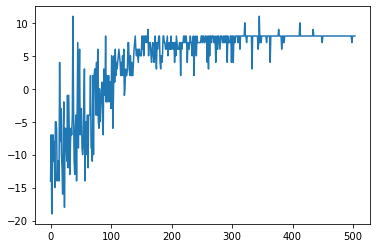

In [160]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions

agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
rh = agent.run(env, 500, verbose=False)

pd.Series(rh).plot()

Session: 0
Session: 1
Session: 2


<AxesSubplot:>

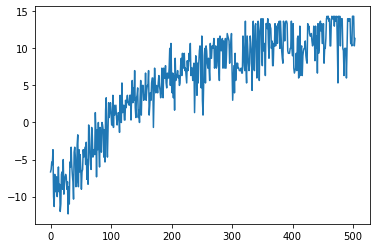

In [158]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions

rhs = []
for i in range(3):
    print("Session:", i)
    agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
    rh = agent.run(env, 500)
    rhs.append(pd.Series(rh))
        
pd.concat(rhs, axis=1).mean(axis=1).plot()

Session: 0
Session: 1
Session: 2


<AxesSubplot:>

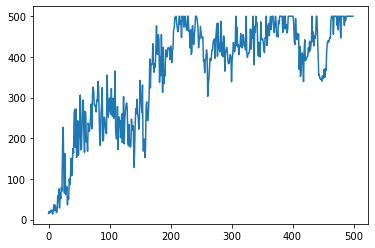

In [159]:
env_names = ['CartPole-v1', 'LunarLander-v2','Acrobot-v1', 'MountainCar-v0']
env = gym.make(env_names[0])
NUM_OBS = env.observation_space.shape[0]
NUM_ACTS = env.action_space.n

rhs = []
for i in range(3):
    print("Session:", i)
    agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)
    rh = agent.run(env, 500)
    rhs.append(pd.Series(rh))
        
pd.concat(rhs, axis=1).mean(axis=1).plot()